# AR和PSY情绪类技术因子均线得分策略 - 第四组 - 陈孜越

策略概述：
1.	构造了AR和PSY情绪类技术指标，再将两个指标的均线组得分加总，总得分若超过一定阈值则生成金叉信号，若低于一定阈值则生成死叉信号。
2.	趋势识别，利用收盘价均线金叉死叉进行上涨和下跌趋势的识别，上涨标记为1，下跌标记为-1
3.  每小时进行调仓判断。若品种处于上涨趋势且金叉信号出现则做多，若品种处于下跌趋势且死叉信号出现则做空，其他情形则说明趋势不够明朗，因此进行平多或平空。
4.	每分钟进行止盈止损的判断 

In [1]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import pandas as pd
import numpy as np

########################################################################
# 策略继承CtaTemplate
class ARPSYMaStrategy(CtaTemplate):
   
    className = 'ARPSYMaStrategy'
    author = 'Chenziyue'
    
    # 策略参数
    fastPeriod = 6   # 判断趋势用到的短期均线时间长度 
    slowPeriod = 60   # 判断趋势用到的长期均线时间长度
    arPeriod = 15     # AR指标的时间参数
    psyPeriod = 12     # PSY指标的时间参数
    timePeriod = 18   # 均线组的个数
    multiplier = 4    # 长短期乘数
    upperthreshold = 0.65   # 买进的分数门槛
    lowerthreshold = 0.4   # 卖出的分数门槛
    stopRatio = 0.03    # 止损率
    lot = 1             # 设置手数
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod',
                 'arPeriod',
                 'psyPeriod',
                 'timePeriod',
                 'multiplier',
                 'upperthreshold',
                 'lowerthreshold',
                 'stopRatio',
                 'lot']    
    
    # 变量列表
    varList = ['maTrend',
               'transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.maTrend = {s:0 for s in self.symbolList} 
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
    
    #----------------------------------------------------------------------
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+5*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-5*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                #print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                #print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                #print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                #print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势-------------------------------------------------
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        if (fastMa[-1] > slowMa[-1]) and (fastMa[-2] < slowMa[-2]):
            self.maTrend[symbol] = 1
        elif (fastMa[-1] < slowMa[-1]) and (fastMa[-2] > slowMa[-2]):
            self.maTrend[symbol] = -1        
       
        
        # 计算策略需要的信号-------------------------------------------------
        def calculate(factor,t):
            mas = ta.MA(factor, t)
            mal = ta.MA(factor, self.multiplier*t)
            df = np.vstack((mas,mal))
            scoretable = np.array(list(map(lambda s, l: 1 if s>l else 0, df[0,:], df[1,:])))
            return scoretable
        
        ar = ta.SUM(am60.high[1:]-am60.open[1:],self.arPeriod)/ta.SUM(am60.open[1:]-am60.low[1:],self.arPeriod)
        x = range(1,self.timePeriod+1,1)
        arscore = np.array([calculate(ar,t) for t in x]).transpose().sum(axis=1)
            
        psy = ta.SUM(np.array(am60.close[1:]>am60.close[:-1],dtype='double'),self.psyPeriod)/self.psyPeriod
        psyscore = np.array([calculate(psy,t) for t in x]).transpose().sum(axis=1)
        
        score = arscore+psyscore
     
        crossOver = (score[-1]>2*self.timePeriod*self.upperthreshold) and (score[-2]<2*self.timePeriod*self.upperthreshold)
        crossBelow = (score[-1]<2*self.timePeriod*self.lowerthreshold) and (score[-2]>2*self.timePeriod*self.lowerthreshold)
        
        
        # 构建进出场逻辑-------------------------------------------------
        # 如果趋势向上且金叉出现
        if (self.maTrend[symbol]==1) and (crossOver):
            # 如果没有空头持仓，且持多仓位小于5，则直接做多
            if (self.posDict[symbol+'_SHORT']==0) and (self.posDict[symbol+'_LONG']<5):
                self.cancelAll()
                self.buy(symbol, bar.close*1.05, self.lot)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.05, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.05, self.lot)
        # 如果（趋势向上且死叉出现） 或者 （趋势向下且金叉出现）
        elif ((self.maTrend[symbol]==1) and (crossBelow)) or ((crossOver) and (self.maTrend[symbol]==-1)):
            # 有多平多，有空平空
            if self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.95, self.posDict[symbol+'_LONG'])
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll()
                self.cover(symbol, bar.close*1.05, self.posDict[symbol+'_SHORT'])
        # 如果死叉出现，趋势向下
        elif (crossBelow) and (self.maTrend[symbol]==-1):
            # 如果没有多头持仓，则直接做空
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']<5):
                self.cancelAll()
                self.short(symbol, bar.close*0.95, self.lot)
            # 如果有多头持仓，则先平多，再做空
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll()
                self.sell(symbol, bar.close*0.95, self.posDict[symbol+'_LONG']) 
                self.short(symbol, bar.close*0.95, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-24 00:25:09.057147	开始回测
2018-12-24 00:25:09.057147	策略初始化
2018-12-24 00:25:09.243705	数据载入完成, 时间段:[20180529 22:00,20180601 00:00);数据量:3000
2018-12-24 00:25:09.244647	初始化预加载数据成功, 数据长度:3000
2018-12-24 00:25:09.244647	策略初始化完成
2018-12-24 00:25:09.244647	策略启动完成
2018-12-24 00:25:09.244647	回测时间范围:[20180601 00:00,20181201 00:00)
2018-12-24 00:25:09.244647	当前回放的时间段:[20180601 00:00,20181201 00:00)
2018-12-24 00:25:16.634885	数据载入完成, 时间段:[20180601 00:00,20181201 00:00);数据量:261728
2018-12-24 00:25:16.753602	数据载入完成, 时间段:[20180531 08:51,20180603 00:01);数据量:3789
2018-12-24 00:25:18.256578	数据载入完成, 时间段:[20180424 03:00,20180531 08:50);数据量:53630
2018-12-24 00:25:18.262564	WARNING: 该时间段:[20180603 00:01,20180603 01:00) 数据量为0!
2018-12-24 00:25:41.096474	回放结束ress: 100%    
2018-12-24 00:25:41.097472	计算按日统计结果
2018-12-24 00:25:41.123432	------------------------------
2018-12-24 00:25:41.123432	首个交易日：	2018-06-01 00:00:00
2018-12-24 00:

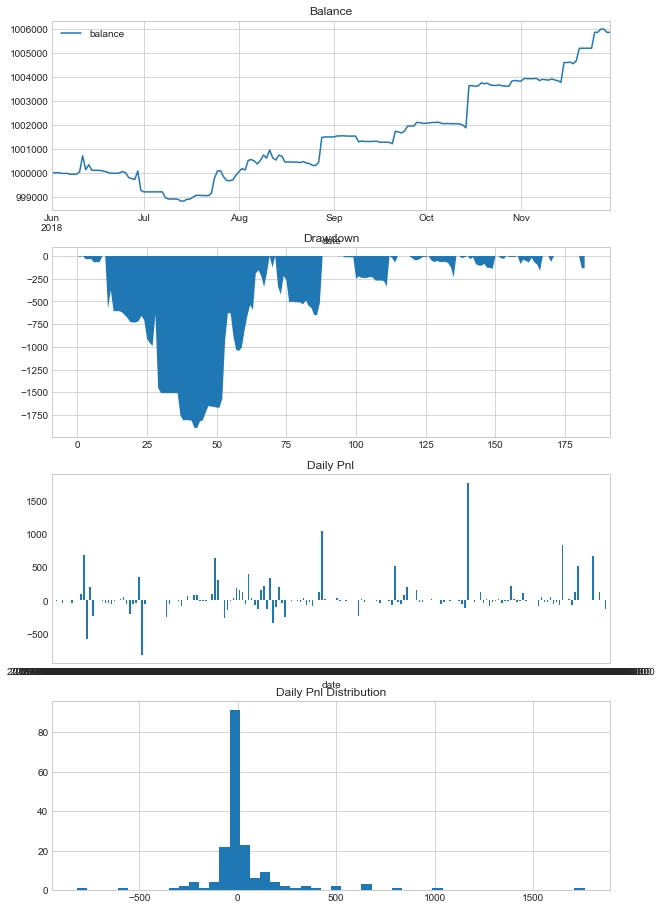

2018-12-24 00:25:43.045260	计算回测结果
2018-12-24 00:25:43.054236	------------------------------
2018-12-24 00:25:43.054236	第一笔交易：	2018-06-02 14:00:00
2018-12-24 00:25:43.054236	最后一笔交易：	2018-11-29 12:06:00
2018-12-24 00:25:43.054236	总交易次数：	123
2018-12-24 00:25:43.055235	总盈亏：	5,873.69
2018-12-24 00:25:43.055235	最大回撤: 	-1,569.55
2018-12-24 00:25:43.055235	平均每笔盈利：	47.75
2018-12-24 00:25:43.055235	平均每笔滑点：	0.0
2018-12-24 00:25:43.055235	平均每笔佣金：	6.62
2018-12-24 00:25:43.055235	胜率		39.02%
2018-12-24 00:25:43.055235	盈利交易平均值	228.25
2018-12-24 00:25:43.055235	亏损交易平均值	-67.77
2018-12-24 00:25:43.055235	盈亏比：	3.37


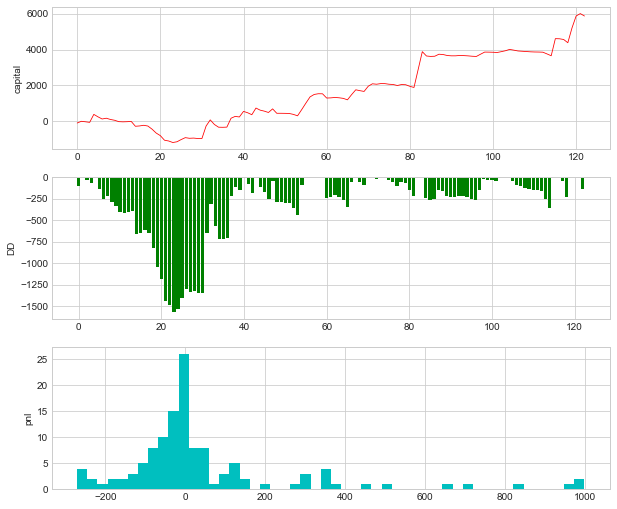

In [2]:
# 对BTCUSDT半年的回测

from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 00:00',initHours=50) # 设置回测用的数据起始日期
engine.setEndDate('20181201 00:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(ARPSYMaStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-24 00:25:43.833154	开始回测
2018-12-24 00:25:43.833154	策略初始化
2018-12-24 00:25:43.926903	数据载入完成, 时间段:[20171229 22:00,20180101 00:00);数据量:3000
2018-12-24 00:25:43.926903	初始化预加载数据成功, 数据长度:3000
2018-12-24 00:25:43.927900	策略初始化完成
2018-12-24 00:25:43.927900	策略启动完成
2018-12-24 00:25:43.927900	回测时间范围:[20180101 00:00,20181201 00:00)
2018-12-24 00:25:43.927900	当前回放的时间段:[20180101 00:00,20181201 00:00)
2018-12-24 00:25:57.991294	数据载入完成, 时间段:[20180101 00:00,20181201 00:00);数据量:476984
2018-12-24 00:25:58.107983	数据载入完成, 时间段:[20171231 08:51,20180103 00:01);数据量:3789
2018-12-24 00:25:59.544141	数据载入完成, 时间段:[20171124 03:00,20171231 08:50);数据量:43654
2018-12-24 00:25:59.549128	WARNING: 该时间段:[20180103 00:01,20180103 01:00) 数据量为0!
2018-12-24 00:26:38.776626	回放结束ress: 100%    
2018-12-24 00:26:38.776626	计算按日统计结果
2018-12-24 00:26:38.802557	------------------------------
2018-12-24 00:26:38.802557	首个交易日：	2018-01-01 00:00:00
2018-12-24 00:

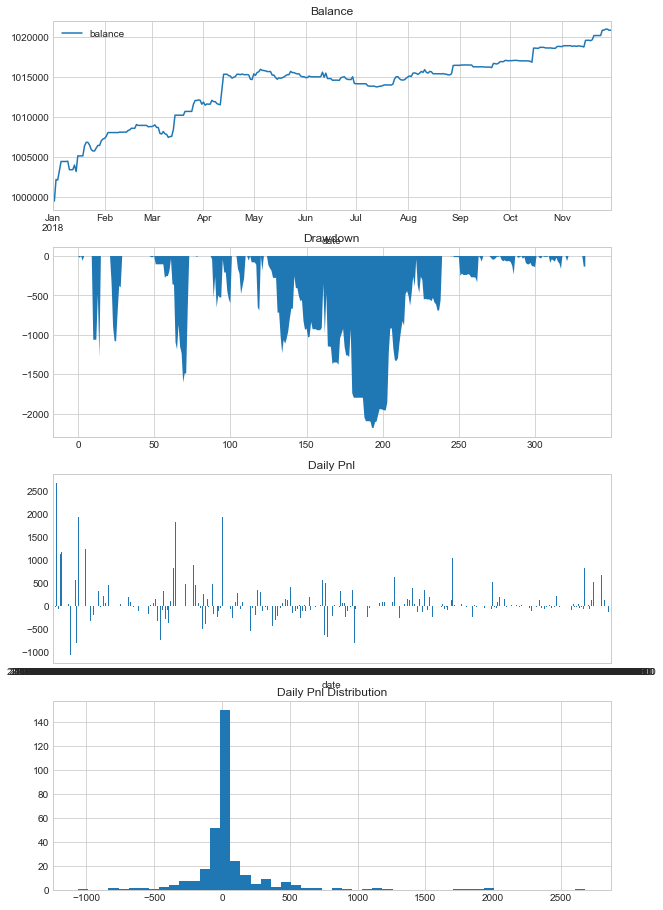

2018-12-24 00:26:42.043891	计算回测结果
2018-12-24 00:26:42.063837	------------------------------
2018-12-24 00:26:42.063837	第一笔交易：	2018-01-01 19:06:00
2018-12-24 00:26:42.063837	最后一笔交易：	2018-11-29 12:06:00
2018-12-24 00:26:42.063837	总交易次数：	230
2018-12-24 00:26:42.063837	总盈亏：	20,828.63
2018-12-24 00:26:42.063837	最大回撤: 	-2,216.96
2018-12-24 00:26:42.063837	平均每笔盈利：	90.56
2018-12-24 00:26:42.063837	平均每笔滑点：	0.0
2018-12-24 00:26:42.063837	平均每笔佣金：	7.91
2018-12-24 00:26:42.063837	胜率		44.78%
2018-12-24 00:26:42.063837	盈利交易平均值	355.68
2018-12-24 00:26:42.063837	亏损交易平均值	-124.46
2018-12-24 00:26:42.064834	盈亏比：	2.86


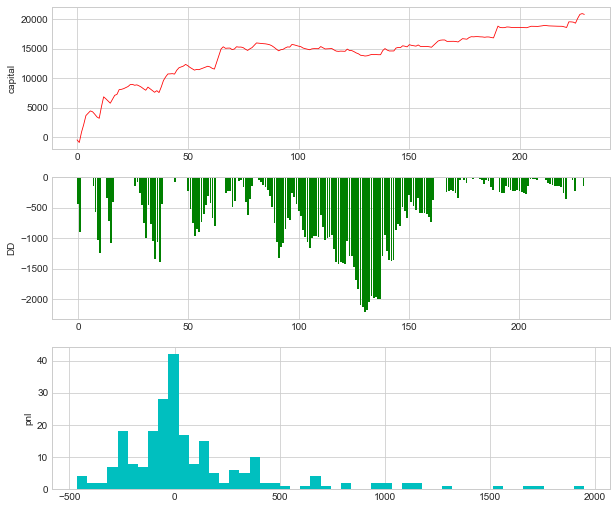

In [3]:
# 对BTCUSDT全年的回测

from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180101 00:00',initHours=50) # 设置回测用的数据起始日期
engine.setEndDate('20181201 00:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(ARPSYMaStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [4]:
# 对EOSUSDT的回测

from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180701 00:00',initHours=50) # 设置回测用的数据起始日期
engine.setEndDate('20181201 00:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(3/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(ARPSYMaStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2018-12-24 00:26:42.811837	开始回测
2018-12-24 00:26:42.811837	策略初始化
2018-12-24 00:26:42.910611	数据载入完成, 时间段:[20180628 22:00,20180701 00:00);数据量:3000
2018-12-24 00:26:42.910611	初始化预加载数据成功, 数据长度:3000
2018-12-24 00:26:42.910611	策略初始化完成
2018-12-24 00:26:42.910611	策略启动完成
2018-12-24 00:26:42.910611	回测时间范围:[20180701 00:00,20181201 00:00)
2018-12-24 00:26:42.910611	当前回放的时间段:[20180701 00:00,20181201 00:00)
2018-12-24 00:26:50.106765	数据载入完成, 时间段:[20180701 00:00,20181201 00:00);数据量:219233
2018-12-24 00:26:50.223453	数据载入完成, 时间段:[20180630 08:51,20180703 00:01);数据量:3789
2018-12-24 00:26:51.844448	数据载入完成, 时间段:[20180524 03:00,20180630 08:50);数据量:46565
2018-12-24 00:26:51.848468	WARNING: 该时间段:[20180703 00:01,20180703 01:00) 数据量为0!
2018-12-24 00:26:59.261614	Warning:当前平仓数量大于可平量，实盘下可能拒单, 请小心处理。
2018-12-24 00:26:59.261614	direction:买平;volume:1;eveningDict={'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2018-12-24 00:27:00.331801	W

2018-12-24 00:27:10.650161	计算按日统计结果
2018-12-24 00:27:10.674096	------------------------------
2018-12-24 00:27:10.674096	首个交易日：	2018-07-01 00:00:00
2018-12-24 00:27:10.674096	最后交易日：	2018-11-30 00:00:00
2018-12-24 00:27:10.674096	总交易日：	153
2018-12-24 00:27:10.674096	盈利交易日	42
2018-12-24 00:27:10.674096	亏损交易日：	64
2018-12-24 00:27:10.674096	起始资金：	1000000
2018-12-24 00:27:10.674096	结束资金：	1,000,006.22
2018-12-24 00:27:10.674096	总收益率：	0.0%
2018-12-24 00:27:10.674096	年化收益：	0.0%
2018-12-24 00:27:10.674096	总盈亏：	6.22
2018-12-24 00:27:10.674096	最大回撤: 	-1.71
2018-12-24 00:27:10.674096	百分比最大回撤: -0.0%
2018-12-24 00:27:10.674096	总手续费：	0.34
2018-12-24 00:27:10.674096	总滑点：	0.38
2018-12-24 00:27:10.674096	总成交金额：	1,137.8
2018-12-24 00:27:10.674096	总成交笔数：	168
2018-12-24 00:27:10.674096	日均盈亏：	0.04
2018-12-24 00:27:10.674096	日均手续费：	0.0
2018-12-24 00:27:10.674096	日均滑点：	0.0
2018-12-24 00:27:10.674096	日均成交金额：	7.44
2018-12-24 00:27:10.674096	日均成交笔数：	1.1
2018-12-24 00:27:10.674096	日均收益率：	0.0%
2018-12-24 00:27:10.

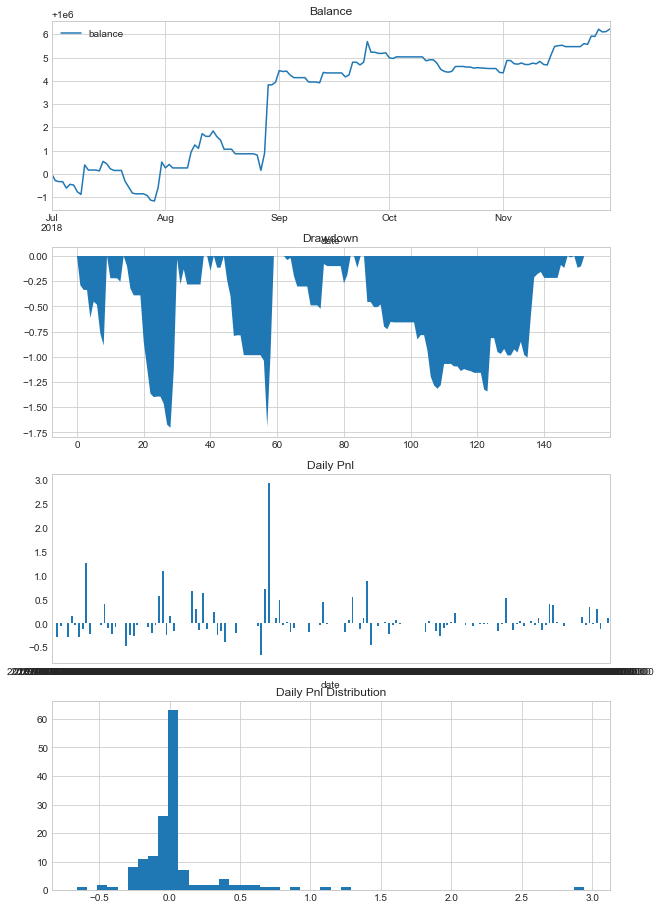

In [5]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-24 00:27:12.439377	计算回测结果
2018-12-24 00:27:12.633856	------------------------------
2018-12-24 00:27:12.633856	第一笔交易：	2018-07-02 21:28:00
2018-12-24 00:27:12.633856	最后一笔交易：	2018-11-30 23:58:00
2018-12-24 00:27:12.633856	总交易次数：	95
2018-12-24 00:27:12.633856	总盈亏：	6.22
2018-12-24 00:27:12.633856	最大回撤: 	-1.6
2018-12-24 00:27:12.633856	平均每笔盈利：	0.07
2018-12-24 00:27:12.633856	平均每笔滑点：	0.0
2018-12-24 00:27:12.633856	平均每笔佣金：	0.0
2018-12-24 00:27:12.633856	胜率		38.95%
2018-12-24 00:27:12.633856	盈利交易平均值	0.38
2018-12-24 00:27:12.633856	亏损交易平均值	-0.13
2018-12-24 00:27:12.633856	盈亏比：	2.83


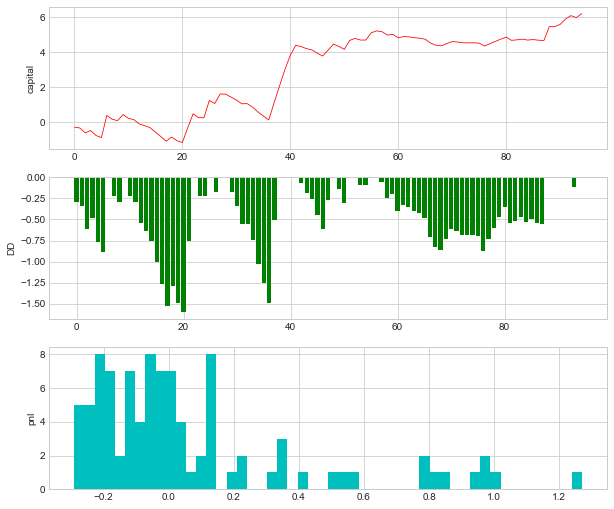

In [6]:
# 显示逐笔回测结果
engine.showBacktestingResult()